# DATASET
The dataset consists of about 159571 comments, which included toxic comments divided into 5 classes. Our aim is train our model so that it can correctly predict whether a given comment is toxic and the category it falls under.

## Importing the required Libraries

In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
import re
import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers


## Importing the Dataset

In [184]:
train = pd.read_csv('data/train.csv/train.csv')
Embedding_file = f'data/glove.6B.50d.txt'

In [149]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [150]:
embedding_size = 50
max_features = 50000
maxlen = 100

## Preprocessing Data

In [151]:
comments_train = train['comment_text'].fillna('_na_').values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
print(comments_train[1])

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)


### Text Cleaning

In [152]:
# Remove URL
def remove_URL(text):
    return re.sub(r'https?://\S+|www\.\S+', '',text)

# Remove square brackets
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

# Remove html tags
def remove_html(text):
    return re.sub(r'<.*?>', '', text)
remove_html("<h1>Vansh Jatana</h1>")

#Remove punctuation
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

#remove the noisy text
for i in range(len(comments_train)):
    comments_train[i] = remove_URL(comments_train[i])
    comments_train[i] = remove_html(comments_train[i])
    comments_train[i] = remove_punct(comments_train[i])  

### Cleaned data example

In [153]:
print(comments_train[1])

Daww He matches this background colour Im seemingly stuck with Thanks  talk  January   UTC


### Tokenizing Text -> Repsesenting each word by a number
Mapping of orginal word to number is preserved in word_index property of tokenizer

Tokenized applies basic processing like changing it to lower case, explicitely setting that as False

Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

In [154]:
token = Tokenizer(num_words=max_features)
token.fit_on_texts(list(comments_train))
tokenized_list_train = token.texts_to_sequences(list(comments_train))

In [155]:
X_train = pad_sequences(tokenized_list_train, maxlen=maxlen)
X_train.shape

(159571, 100)

### GloVe Embeddings

In [156]:
embedding_index = dict()
f = open('data/glove.6B.50d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embedding_index[word] = coefs
f.close()
print(len(embedding_index))

400000


In [157]:
embedding_matrix = np.zeros((max_features, 50))
for word, i in token.word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Training the Model

In [158]:
model=Sequential()
X = model.add(Embedding(max_features, input_length=maxlen, 
        output_dim=embedding_size, weights=[embedding_matrix], trainable= False))
X = model.add(Bidirectional(GRU(80, return_sequences = True, dropout=0.1, recurrent_dropout=0.1)))
X = model.add(GlobalMaxPool1D())
X = model.add(Dense(50, activation='relu'))
X = model.add(Dropout(0.1))
X = model.add(Dense(6, activation='sigmoid'))

In [159]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           2500000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 160)          62880     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 160)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                8050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 306       
Total params: 2,571,236
Trainable params: 71,236
Non-trainable params: 2,500,000
_______________________________________

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y, train_size= 0.9, random_state=233)

In [161]:
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.1)

Train on 129251 samples, validate on 14362 samples
Epoch 1/2
129251/129251 [==============================] - 2479s 19ms/step - loss: 0.0789 - accuracy: 0.9748 - val_loss: 0.0598 - val_accuracy: 0.9789
Epoch 2/2
129251/129251 [==============================] - 2494s 19ms/step - loss: 0.0647 - accuracy: 0.9786 - val_loss: 0.0578 - val_accuracy: 0.9791


## Training and Validation Accuracy

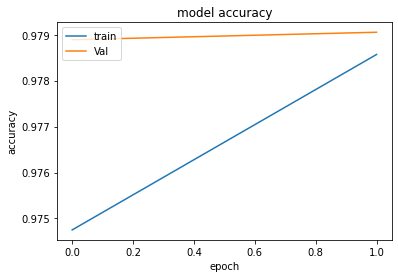

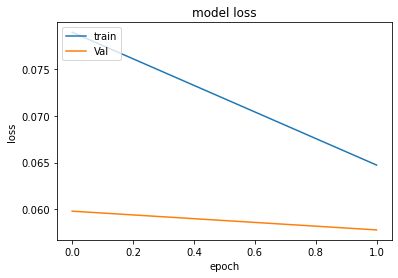

In [164]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

## Test Accuracy

In [165]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

15958/15958 [==============================] - 29s 2ms/step
Loss = 0.05940162921227493
Test Accuracy = 0.9789032936096191
